## Mechanisms for DP Histogram Releases and Synthetic Data

In [2]:
##
##  histogramRelease.r
##
##  demonstrate mechanisms for histogram release and synthetic data generation
##
##  jH 2019.3.8
##

rm(list=ls())		# Remove any objects in memory

#### Parameters ####

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}


# Probability density for Laplace distribution
#
# x numeric, value
# mu numeric, center of the distribution
# b numeric, spread
# 
# return Density for elements of x
# example:
# 
# x <- seq(-3, 3, length.out=61)
# dlap(x)

dlap <- function(x, mu=0, b=1) {
    dens <- 0.5 * b * exp(-1 * abs(x - mu) / b)
    return(dens)
}


# Laplace Cumulative Distribution Function
# 
# Determines the probability a draw from a LaPlace distribution is less than 
#    or equal to the specified value.
#
# x Numeric, the value(s) at which the user wants to know the CDF height.
# mu Numeric, the center of the LaPlace distribution, defaults to 0.
# b Numeric, the spread of the LaPlace distribution, defaults to 1.
# 
# return Probability the LaPlace draw is less than or equal to \code{x}.
# example:
# 
# x <- 0
# plap(x)

plap <- function(x, mu=0, b=1) {
    cdf <- 0.5 + 0.5 * sgn(x - mu) * (1 - exp(-1 * (abs(x - mu) / b)))
    return(cdf)
}


# Quantile function for Laplace distribution
#
# p Numeric, vector of probabilities
# mu numeric, center of the distribution
# b numeric, spread
# return Quantile function
# example:
#
# probs <- c(0.05, 0.50, 0.95)
# qlap(probs)

qlap <- function(p, mu=0, b=1) {
    q <- ifelse(p < 0.5, mu + b * log(2 * p), mu - b * log(2 - 2 * p))
    return(q)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))


sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}

## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}

## Sample with replacement from a vector
bootstrap <- function(x, y=NULL, n){
	index <- sample(x=1:length(x), size=n, replace=TRUE) 

	if(is.null(y)){
		return(x[index])
	}else{
		return(list(x=x[index], y=y[index]))
	}
}

showHist <- function(release, main="Histogram"){

	semi.blue <- rgb(0,90,239,150,maxColorValue=255)          # Slightly transparent colors
	semi.red  <- rgb(239,90,0,150,maxColorValue=255)

	DPrelease <- release$release
	codebook <- release$codebook
	true <- release$true

	allylim <- c(min(c(DPrelease,true), na.rm = TRUE), max(c(DPrelease, true), na.rm = TRUE))
	granularity <- (max(codebook) - min(codebook))/(length(codebook)-1)

	allxlim <- c(min(codebook) - 0.5*granularity, max(codebook + 0.5*granularity))

	# If stability threshold would be off the graph, extend range of graph
    if(!is.null(release$threshold)){
    	print(release$threshold)
    	print(allylim)
    	if(release$threshold>allylim[2]){
    		allylim[2]<-release$threshold
    	}
    }

    # Build empty plot
	plot.new()
	plot.window( xlim=allxlim, ylim=allylim)
	title(main = main)
	axis( side=1 )
	axis( side=2 )

	tiny <- granularity*0.03 # slight spacing between bars
	overlap <- granularity*0.2 # some small overlap between sensitive and DP values

	for(i in 1:length(codebook)){
		rect(xleft=codebook[i]-overlap, ybottom=0, xright=codebook[i]+0.5*granularity-tiny, ytop=true[i], col=semi.red)
		rect(xleft=codebook[i]-0.5*granularity+tiny, ybottom=0, xright=codebook[i]+overlap, ytop=DPrelease[i], col=semi.blue)
	}

	# If present, show stability threshold
	if(!is.null(release$threshold)){
		abline(h=release$threshold, col="black", lty=2, lwd=1.5)
	}
}


library("foreign")
PUMSdata <- read.csv(file="https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/FultonPUMS5full.csv")     

data <- PUMSdata$educ    		# variable for means
data.x <- PUMSdata$educ			# x-variable for regression
data.y <- PUMSdata$income		# y-variable for regression

In [3]:
## Differentially private histogram for integers
integerHistogramRelease <- function(x, lower, upper, nbins=0, epsilon){
	n <- length(x)
	if(nbins==0){
		lower <- floor(lower)
		upper <- ceiling(upper)
		bins <- lower:upper   
        nbins <- length(bins)
        codebook <- bins
    }

    x.clipped <- clip(x=x, lower=lower, upper=upper)

	sensitivity <- 1   # correct this (?)
	scale <- sensitivity / epsilon

	sensitiveValue <- DPrelease <- rep(NA,nbins)
	for(i in 1:length(bins)){
		sensitiveValue[i] <- sum(x.clipped==bins[i])
		DPrelease[i] <- sensitiveValue[i] + rlap(mu=0, b=scale, size=1)
	}

	return(list(release=DPrelease, true=sensitiveValue, codebook=codebook))
}

 [1]  3  1  3  3  2  4  9  7 38  6 30  9 51 26  6  2


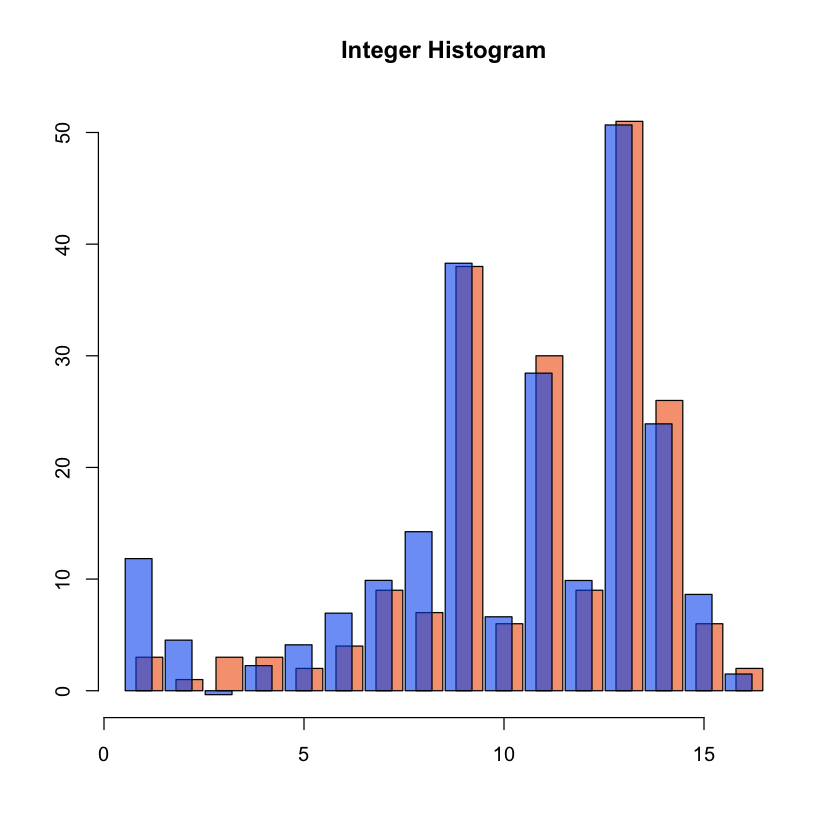

In [4]:
data1 <- bootstrap(data, n=200)
out.1 <- integerHistogramRelease(x=data1, lower=1, upper=16, epsilon=0.5)

showHist(out.1, main="Integer Histogram")

In [ ]:
## Differentially private histogram for continuous
continuousHistogramRelease <- function(x, lower, upper, nbins=0, epsilon){
	n <- length(x)
	if(nbins==0){
		lower <- floor(lower)
		upper <- ceiling(upper)
		bins <- lower:(upper+1)          # understand this
		nbins <- length(bins)-1          # understand this
		codebook <- bins[1:nbins] 
    } else {
    	bins <- seq(from=lower, to=upper, length=nbins+1)
    	granularity <- (upper-lower)/nbins
    	bins[nbins+1] <-  bins[nbins+1] + granularity      # understand this 
    	codebook <- bins[1:nbins] + 0.5*granularity
    }

    x.clipped <- clip(x=x, lower=lower, upper=upper)

	sensitivity <- 2
	scale <- sensitivity / epsilon

	sensitiveValue <- DPrelease <- rep(NA,nbins)
	for(i in 1:nbins){
		sensitiveValue[i] <- 1                         						# correct this
		DPrelease[i] <- sensitiveValue[i] + rlap(mu=0, b=scale, size=1)
	}

	return(list(release=DPrelease, true=sensitiveValue, codebook=codebook))
}

In [ ]:
data2 <- bootstrap(data.y, n=200)
out.2 <- continuousHistogramRelease(x=data2, lower=0, upper=100000, nbins=10, epsilon=0.5)

showHist(out.2, main="Continuous Histogram")

In [ ]:
## Differentially private histogram with stability mechanism
stabilityHistogramRelease <- function(x, lower, upper, nbins=0, epsilon, delta){
	n <- length(x)
	if(nbins==0){
		lower <- floor(lower)
		upper <- ceiling(upper)
		bins <- lower:(upper+1)    # For integers, this is just lower:upper
		nbins <- length(bins)
		codebook <- bins[1:nbins] 
    } else {
    	bins <- seq(from=lower, to=upper, length=nbins+1)
    	granularity <- (upper-lower)/nbins
    	bins[nbins+1] <-  bins[nbins+1] + granularity 
    	codebook <- bins[1:nbins] + 0.5*granularity
    }

    x.clipped <- clip(x=x, lower=lower, upper=upper)

	sensitivity <- 2
	scale <- sensitivity / epsilon
	a <- 2*log(1/delta)/epsilon

	sensitiveValue <- DPrelease <- rep(NA,length(bins))            
	for(i in 1:nbins){                                                            # Vectorize this entire loop
		sensitiveValue[i] <- sum(x.clipped>=bins[i] & x.clipped <=bins[i+1])
        potentialRelease <- sensitiveValue[i] + rlap(mu=0, b=scale, size=1)

		if (potentialRelease > a){													
			DPrelease[i] <- potentialRelease
		} else {
			DPrelease[i] <- 0
		}
	}

	return(list(release=DPrelease, true=sensitiveValue, codebook=codebook, threshold=a))
}

In [ ]:
data3 <- bootstrap(data.y, n=200)
out.3 <- stabilityHistogramRelease(x=data3, lower=0, upper=100000, nbins=10, epsilon=0.5, delta=0.000001)

showHist(out.3, main="Stability Histogram")

In [ ]:
## Differentially private histogram for continuous
xyHistogramRelease <- regressionRelease <- function(y, x, ylower, yupper, xlower, xupper, xnbins=0, ynbins=0, epsilon){
	n <- length(x)
	if(xnbins==0){
		xlower <- floor(xlower)
		xupper <- ceiling(xupper)
		xbins <- xlower:(xupper+1)    
		xnbins <- length(xbins)-1
		xgranularity <- 1
		xcodebook <- xbins[1:xnbins]
    } else {
    	xbins <- seq(from=xlower, to=xupper, length=xnbins+1)
    	xgranularity <- (xupper-xlower)/xnbins
    	xbins[xnbins+1] <-  xbins[xnbins+1] + xgranularity
		xcodebook <- xbins[1:xnbins] + 0.5*xgranularity
    }

	if(ynbins==0){
		ylower <- floor(ylower)
		yupper <- ceiling(yupper)
		ybins <- ylower:(yupper+1)    
		ynbins <- length(ybins)-1
		ygranularity <- 1
		ycodebook <- ybins[1:ynbins]
    } else {
    	ybins <- seq(from=ylower, to=yupper, length=ynbins+1)
    	ygranularity <- (yupper-ylower)/ynbins
    	ybins[ynbins+1] <-  ybins[ynbins+1] + ygranularity
    	ycodebook <- ybins[1:ynbins] + 0.5*ygranularity
    }

    x.clipped <- clip(x=x, lower=xlower, upper=xupper)
    y.clipped <- clip(x=y, lower=ylower, upper=yupper)

	sensitivity <- 2
	scale <- sensitivity / (epsilon)

	sensitiveValue <- DPrelease <- matrix(NA, nrow=ynbins, ncol=xnbins)

	for(i in 1:xnbins){
		for(j in 1:ynbins){
			sensitiveValue[j,i] <- sum(x.clipped >= xbins[i] & x.clipped < xbins[i+1] & y.clipped >= ybins[j] & y.clipped < ybins[j+1])
			DPrelease[j,i] <- sensitiveValue[j,i] + rlap(mu=0, b=scale, size=1)
		}
	}

	return(list(release=DPrelease, true=sensitiveValue, xcodebook=xcodebook, ycodebook=ycodebook))
}

In [ ]:
myn<-1000
data4 <- bootstrap(x=data.x, y=data.y, n=myn)
out.4 <- xyHistogramRelease(y=data4$y, x=data4$x, ylower=0, yupper=100000, xlower=1, xupper=16, xnbins=0, ynbins=10, epsilon=0.5)

## Plot the 2-dimensional histogram

par(mfcol=c(2,1))

 library(plotrix)
 cellcol<-matrix("#808080",nrow=nrow(out.4$true),ncol=ncol(out.4$true))
 cellcol[out.4$true>0]<-color.scale(out.4$true[out.4$true>0],0,c(0.8,1),c(0.8,0))

 color2D.matplot(x=out.4$true, yrev=FALSE, show.values=TRUE,main="Sensitive Data", axes=FALSE, cellcol=cellcol, xlab="education", ylab="income")
 axis(side=1, at=(1:ncol(out.4$true))-0.5, labels=out.4$xcodebook )
 axis(side=2, at=(1:nrow(out.4$true))-0.5, labels=out.4$ycodebook )
 

 cellcol<-matrix("#808080",nrow=nrow(out.4$release),ncol=ncol(out.4$release))
 cellcol[out.4$release>0]<-color.scale(out.4$release[out.4$release>0],0,c(0.8,1),c(0.8,0))
 cellcol[out.4$release<0]<-color.scale(out.4$release[out.4$release<0],c(1,0.8),c(0,0.8),0)

 color2D.matplot(x=out.4$release, yrev=FALSE, show.values=TRUE,main="DP Release", axes=FALSE, cellcol=cellcol, xlab="education", ylab="income")
 axis(side=1, at=(1:ncol(out.4$release))-0.5, labels=out.4$xcodebook )
 axis(side=2, at=(1:nrow(out.4$release))-0.5, labels=out.4$ycodebook )

**Show synthetic data generation

In [ ]:
## Post-process a vector or matrix of DP count releases, into probabilities
normalize <- function(x){
	x[x<0] <- 0
	x <- x/sum(x)
	return(x)
}

data4$y <- clip(data4$y, lower=0, upper=100000)

true.cor <- cor(data4$x, data4$y)
true.output <- lm(data4$y~data4$x)
true.slope <- coef(true.output)[2]
nsims <- 20

## Bad Synthetic Data

badhistory <-matrix(NA, nrow=nsims, ncol=2)

for(i in 1:nsims){

	out.x <- integerHistogramRelease(x=data4$x, lower=1, upper=16, epsilon=0.5)
	out.y <- continuousHistogramRelease(x=data4$y, lower=0, upper=100000, nbins=10, epsilon=0.5)

	prob.x <- normalize(out.x$release)
	syn.x <- rmultinom(n=myn, prob=prob.x,  size=1) 
	syn.x <- t(syn.x) %*% out.x$codebook

	prob.y <- normalize(out.y$release)
	syn.y <- rmultinom(n=myn, prob=prob.y,  size=1) 
	syn.y <- t(syn.y) %*% out.y$codebook

	output <- lm(syn.y ~ syn.x)

	badhistory[i,1] <- cor(syn.x, syn.y)
	badhistory[i,2] <- output$coef[2]
}


## Good Synthetic Data

goodhistory <-matrix(NA, nrow=nsims, ncol=2)
for(i in 1:nsims){
	out.4 <- xyHistogramRelease(y=data4$y, x=data4$x, ylower=0, yupper=100000, xlower=1, xupper=16, xnbins=0, ynbins=10, epsilon=0.5)

	syn.prob <- as.vector(normalize(out.4$release))
	syn.xy <- rmultinom(n=myn, prob=syn.prob, size=1)
	syn.x <- t(syn.xy) %*% sort(rep(out.4$xcodebook, nrow(out.4$release)))
	syn.y <- t(syn.xy) %*% rep(out.4$ycodebook, ncol(out.4$release))

	output <- lm(syn.y ~ syn.x)

	goodhistory[i,1] <- cor(syn.x, syn.y)
	goodhistory[i,2] <- output$coef[2]
}


## Compare the simulations from the two synthetic approaches

allxlim.cor <- c(min(c(badhistory[,1],goodhistory[,1],true.cor)),max(c(badhistory[,1],goodhistory[,1],true.cor)))
allxlim.slope <- c(min(c(badhistory[,2],goodhistory[,2],true.slope)),max(c(badhistory[,2],goodhistory[,2],true.slope)))

par(mfcol=c(2,1))
plot(density(badhistory[,1]), col="purple", lwd=1.5, xlim=allxlim.cor, main="correlations")
abline(v=true.cor, col="red")
gooddens <- density(goodhistory[,1])
lines(gooddens$x,gooddens$y, col="green", lwd=1.5)

plot(density(badhistory[,2]), col="purple", lwd=1.5, xlim=allxlim.slope, main="regression slopes")
abline(v=true.slope, col="red")
gooddens <- density(goodhistory[,2])
lines(gooddens$x,gooddens$y, col="green", lwd=1.5)